In [ ]:
pip install scikit-image skan

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 19.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.8/126.8 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 842.5/842.5 kB 28.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.0/95.0 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.7/99.7 kB 7.5 MB/s eta 0:00:00


Jump distance: 8 pixels
Angle threshold to ignore very high curvature: 0.9000 radians

--- Estadísticas Globales de Curvatura ---
Curvatura Máxima Global: 2.0420 rad
Curvatura Mínima Global: 0.0000 rad
Curvatura Media Global: 0.3106 rad

--- Estadísticas de Curvatura por Cuadrante ---
  Cuadrante Superior Izquierdo (TL):
    Máxima: 1.7705 rad
    Mínima: 0.0000 rad
    Media: 0.3194 rad
  Cuadrante Superior Derecho (TR):
    Máxima: 2.0344 rad
    Mínima: 0.0000 rad
    Media: 0.2745 rad
  Cuadrante Inferior Izquierdo (BL):
    Máxima: 2.0420 rad
    Mínima: 0.0000 rad
    Media: 0.3821 rad
  Cuadrante Inferior Derecho (BR):
    Máxima: 1.3710 rad
    Mínima: 0.0000 rad
    Media: 0.2297 rad


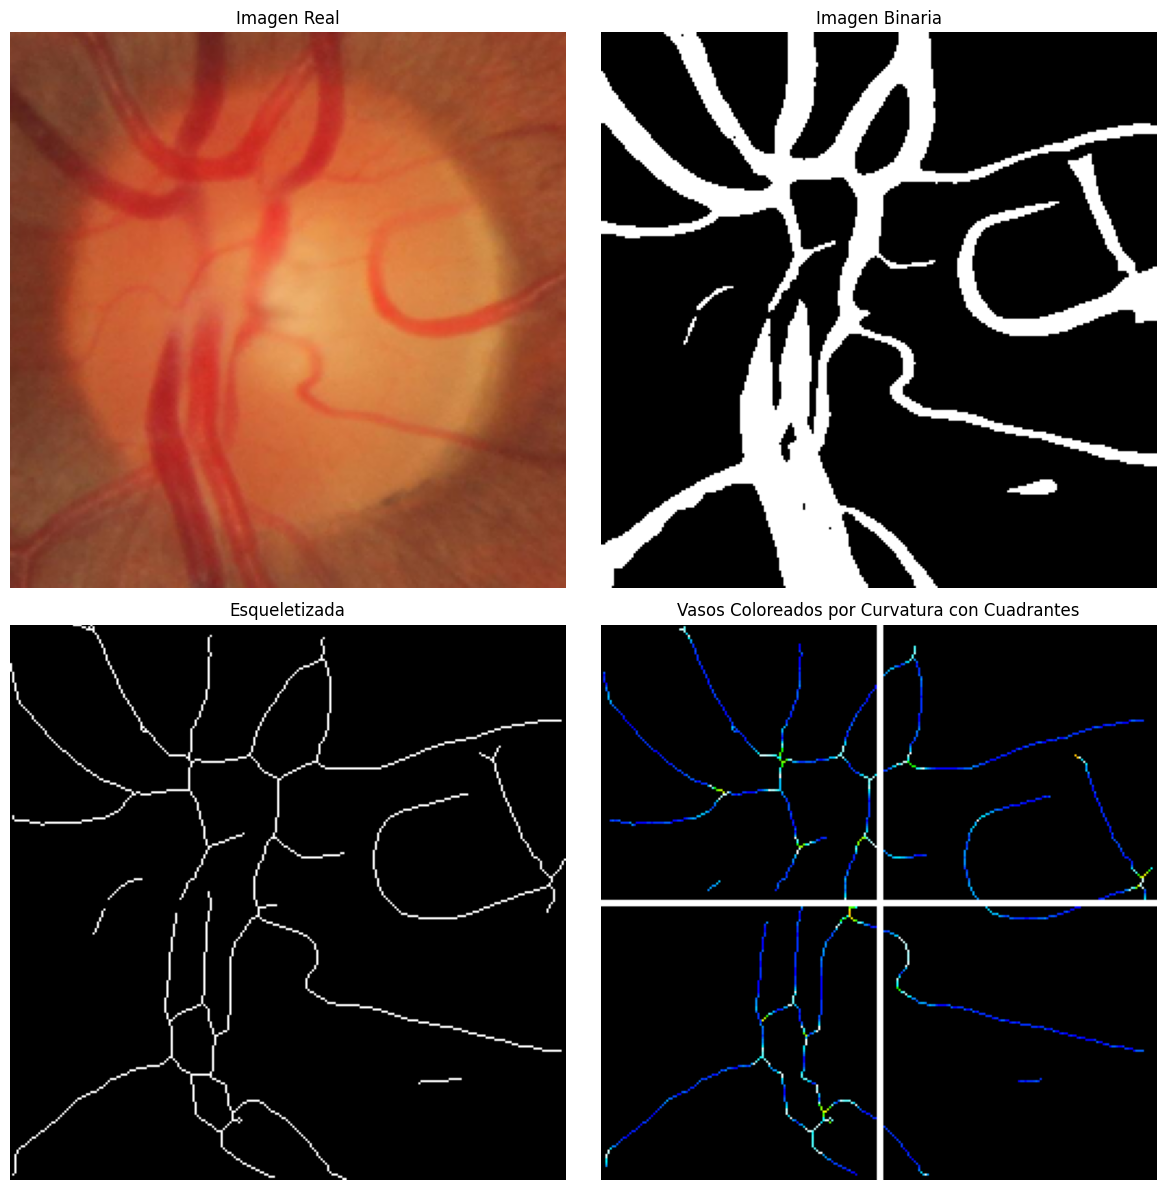

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.morphology import skeletonize

img_path = "/content/drive/MyDrive/4º Curso/Segundo cuatrimestre/TFG/segmentadas/r2_Im036.png"
img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

binary = (img > 0).astype(np.uint8) * 255

skeleton = skeletonize(binary // 255).astype(np.uint8) * 255

def angle_between(p1, p2, p3):
    """Compute angle (in radians) between vectors p1->p2 and p2->p3"""
    v1 = np.array(p1) - np.array(p2)
    v2 = np.array(p3) - np.array(p2)
    dot_product = np.dot(v1, v2)
    norm_product = np.linalg.norm(v1) * np.linalg.norm(v2)
    if norm_product == 0:
        return 0

    angle = np.arccos(np.clip(dot_product / norm_product, -1.0, 1.0))
    return angle

def curvature_to_color(angle):
    """Map curvature (angle) to a BGR color: blue for straight, red for curvy"""
    # Normalizamos el ángulo de 0 a 1 (0 es muy curvado, 1 es recto)
    angle_norm = angle / np.pi

    if angle_norm > 0.8: # Muy recto (curvatura baja)
        return (255, int(255 * (1 - (angle_norm - 0.8) / 0.2)), 0) # Azul a cian
    elif angle_norm > 0.6: # Recto
        return (255, 255, int(255 * ((angle_norm - 0.6) / 0.2))) # Cian a amarillo
    elif angle_norm > 0.4: # Curvatura moderada
        return (0, 255, int(255 * (1 - (angle_norm - 0.4) / 0.2))) # Amarillo a naranja
    elif angle_norm > 0.2: # Curvado
        return (0, int(255 * ((angle_norm - 0.2) / 0.2)), 255) # Naranja a rojo
    else: # Muy curvado (curvatura alta)
        return (0, 0, 255) # Rojo puro

# Definición de Cuadrantes
height, width = skeleton.shape
center_x, center_y = width // 2, height // 2

# Listas para almacenar curvaturas por cuadrante
curvatures_tl = []
curvatures_tr = []
curvatures_bl = []
curvatures_br = []

all_curvatures = []

# Encuentra los contornos en el esqueleto
contours, _ = cv2.findContours(skeleton, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

colored_canvas = np.zeros((height, width, 3), dtype=np.uint8)

jump = 8 # Distancia para calcular el ángulo

# Umbral de ángulo para ignorar: si el ángulo es menor que esto, se ignora la curvatura.
# Esto ignorará las curvaturas muy cercanas a pi.
ANGLE_TO_IGNORE_THRESHOLD = 0.9

print(f"Jump distance: {jump} pixels")
print(f"Angle threshold to ignore very high curvature: {ANGLE_TO_IGNORE_THRESHOLD:.4f} radians")


for contour in contours:
    contour = np.squeeze(contour)
    if len(contour.shape) == 1:
        continue

    if len(contour) < (2 * jump + 1):
        continue

    for i in range(jump, len(contour) - jump):
        p1 = contour[i - jump]
        p2 = contour[i]
        p3 = contour[i + jump]

        angle = angle_between(p1, p2, p3)

        # IGNORAR CURVATURAS PROBLEMÁTICAS
        # Si el ángulo es muy pequeño (vectores casi opuestos), significa que la curvatura (pi - angle) es muy grande (casi pi).
        # Esto ocurre en los extremos
        if angle < ANGLE_TO_IGNORE_THRESHOLD:
            continue

        curvature_value = np.pi - angle

        all_curvatures.append(curvature_value)

        # Determinar el cuadrante de p2 y almacenar la curvatura
        px, py = p2[0], p2[1]

        if px < center_x and py < center_y:
            curvatures_tl.append(curvature_value)
        elif px >= center_x and py < center_y:
            curvatures_tr.append(curvature_value)
        elif px < center_x and py >= center_y:
            curvatures_bl.append(curvature_value)
        else:
            curvatures_br.append(curvature_value)

        # Colorear el píxel en el lienzo
        color = curvature_to_color(angle)
        cv2.line(colored_canvas, tuple(contour[i-1]), tuple(contour[i]), color, thickness=1)


# Cálculos de Estadísticas de Curvatura por Cuadrante
print("\n--- Estadísticas Globales de Curvatura ---")
if all_curvatures:
    print(f"Curvatura Máxima Global: {np.max(all_curvatures):.4f} rad")
    print(f"Curvatura Mínima Global: {np.min(all_curvatures):.4f} rad")
    print(f"Curvatura Media Global: {np.mean(all_curvatures):.4f} rad")
else:
    print("No se pudieron calcular curvaturas globales (lista vacía).")

print("\n--- Estadísticas de Curvatura por Cuadrante ---")

def print_quadrant_stats(name, curvatures_list):
    if curvatures_list:
        print(f"  {name}:")
        print(f"    Máxima: {np.max(curvatures_list):.4f} rad")
        print(f"    Mínima: {np.min(curvatures_list):.4f} rad")
        print(f"    Media: {np.mean(curvatures_list):.4f} rad")
    else:
        print(f"  {name}: No se detectaron vasos en este cuadrante para el cálculo de curvatura.")

print_quadrant_stats("Cuadrante Superior Izquierdo (TL)", curvatures_tl)
print_quadrant_stats("Cuadrante Superior Derecho (TR)", curvatures_tr)
print_quadrant_stats("Cuadrante Inferior Izquierdo (BL)", curvatures_bl)
print_quadrant_stats("Cuadrante Inferior Derecho (BR)", curvatures_br)


# Visualización
real_image_path = "/content/drive/MyDrive/4º Curso/Segundo cuatrimestre/TFG/reescalado/r2_Im036.png"
try:
    real_image = cv2.imread(real_image_path)
    if real_image is None:
        print(f"Advertencia: No se pudo cargar la imagen real de {real_image_path}. Mostrando solo las imágenes procesadas.")
        fig, axes = plt.subplots(1, 3, figsize=(15, 6))
        axes[0].imshow(binary, cmap='gray')
        axes[0].set_title('Imagen Binaria')
        axes[0].axis('off')
        axes[1].imshow(skeleton, cmap='gray')
        axes[1].set_title('Esqueletizada')
        axes[1].axis('off')
        cv2.line(colored_canvas, (center_x, 0), (center_x, height), (255, 255, 255), 2)
        cv2.line(colored_canvas, (0, center_y), (width, center_y), (255, 255, 255), 2)
        axes[2].imshow(cv2.cvtColor(colored_canvas, cv2.COLOR_BGR2RGB))
        axes[2].set_title("Vasos Coloreados por Curvatura con Cuadrantes")
        axes[2].axis('off')
        plt.tight_layout()
        plt.show()
    else:
        fig, axes = plt.subplots(2, 2, figsize=(12, 12))

        axes[0, 0].imshow(cv2.cvtColor(real_image, cv2.COLOR_BGR2RGB))
        axes[0, 0].set_title('Imagen Real')
        axes[0, 0].axis('off')

        axes[0, 1].imshow(binary, cmap='gray')
        axes[0, 1].set_title('Imagen Binaria')
        axes[0, 1].axis('off')

        axes[1, 0].imshow(skeleton, cmap='gray')
        axes[1, 0].set_title('Esqueletizada')
        axes[1, 0].axis('off')

        cv2.line(colored_canvas, (center_x, 0), (center_x, height), (255, 255, 255), 2)
        cv2.line(colored_canvas, (0, center_y), (width, center_y), (255, 255, 255), 2)

        axes[1, 1].imshow(cv2.cvtColor(colored_canvas, cv2.COLOR_BGR2RGB))
        axes[1, 1].set_title("Vasos Coloreados por Curvatura con Cuadrantes")
        axes[1, 1].axis('off')

        plt.tight_layout()
        plt.show()

except FileNotFoundError:
    print(f"Error: La imagen real en {real_image_path} no fue encontrada. Asegúrate de que la ruta es correcta.")
    fig, axes = plt.subplots(1, 3, figsize=(15, 6))
    axes[0].imshow(binary, cmap='gray')
    axes[0].set_title('Imagen Binaria')
    axes[0].axis('off')
    axes[1].imshow(skeleton, cmap='gray')
    axes[1].set_title('Esqueletizada')
    axes[1].axis('off')
    cv2.line(colored_canvas, (center_x, 0), (center_x, height), (255, 255, 255), 2)
    cv2.line(colored_canvas, (0, center_y), (width, center_y), (255, 255, 255), 2)
    axes[2].imshow(cv2.cvtColor(colored_canvas, cv2.COLOR_BGR2RGB))
    axes[2].set_title("Vasos Coloreados por Curvatura con Cuadrantes")
    axes[2].axis('off')
    plt.tight_layout()
    plt.show()

In [ ]:
pip install opencv-python numpy pandas scikit-image

# Para un repositorio entero

In [ ]:
import cv2
import numpy as np
import pandas as pd
from skimage.morphology import skeletonize
import os

def angle_between(p1, p2, p3):
    v1 = np.array(p1) - np.array(p2)
    v2 = np.array(p3) - np.array(p2)
    dot_product = np.dot(v1, v2)
    norm_product = np.linalg.norm(v1) * np.linalg.norm(v2)
    if norm_product == 0:
        return 0
    angle = np.arccos(np.clip(dot_product / norm_product, -1.0, 1.0))
    return angle

def process_image_for_features(img_path):
    try:
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            print(f"Error: No se pudo cargar la imagen en {img_path}. Saltando.")
            return None

        binary = (img > 0).astype(np.uint8) * 255
        skeleton = skeletonize(binary // 255).astype(np.uint8) * 255

        height, width = skeleton.shape
        center_x, center_y = width // 2, height // 2

        curvatures_tl = []
        curvatures_tr = []
        curvatures_bl = []
        curvatures_br = []
        all_curvatures = []

        contours, _ = cv2.findContours(skeleton, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

        jump = 8
        ANGLE_TO_IGNORE_THRESHOLD = 0.9

        for contour in contours:
            contour = np.squeeze(contour)
            if len(contour.shape) == 1 or len(contour) < (2 * jump + 1):
                continue

            for i in range(jump, len(contour) - jump):
                p1 = contour[i - jump]
                p2 = contour[i]
                p3 = contour[i + jump]

                angle = angle_between(p1, p2, p3)

                if angle < ANGLE_TO_IGNORE_THRESHOLD:
                    continue

                curvature_value = np.pi - angle
                all_curvatures.append(curvature_value)

                px, py = p2[0], p2[1]
                if px < center_x and py < center_y:
                    curvatures_tl.append(curvature_value)
                elif px >= center_x and py < center_y:
                    curvatures_tr.append(curvature_value)
                elif px < center_x and py >= center_y:
                    curvatures_bl.append(curvature_value)
                else:
                    curvatures_br.append(curvature_value)

        # Calcular estadísticas
        features = {
            'Curv_Global_Max': np.max(all_curvatures) if all_curvatures else 0.0,
            'Curv_Global_Mean': np.mean(all_curvatures) if all_curvatures else 0.0,
            'Curv_TL_Max': np.max(curvatures_tl) if curvatures_tl else 0.0,
            'Curv_TL_Mean': np.mean(curvatures_tl) if curvatures_tl else 0.0,
            'Curv_TR_Max': np.max(curvatures_tr) if curvatures_tr else 0.0,
            'Curv_TR_Mean': np.mean(curvatures_tr) if curvatures_tr else 0.0,
            'Curv_BL_Max': np.max(curvatures_bl) if curvatures_bl else 0.0,
            'Curv_BL_Mean': np.mean(curvatures_bl) if curvatures_bl else 0.0,
            'Curv_BR_Max': np.max(curvatures_br) if curvatures_br else 0.0,
            'Curv_BR_Mean': np.mean(curvatures_br) if curvatures_br else 0.0,
        }
        return features

    except Exception as e:
        print(f"Error procesando la imagen {img_path}: {e}")
        return None

# Configuración de rutas
csv_file_path = '/content/drive/MyDrive/4º Curso/Segundo cuatrimestre/TFG/Clasificación/train_RIMONE.csv'
segmented_images_dir = '/content/drive/MyDrive/4º Curso/Segundo cuatrimestre/TFG/Clasificación/train_segmentado'

# Cargar el CSV
try:
    df = pd.read_csv(csv_file_path)
    print(f"CSV '{csv_file_path}' cargado exitosamente.")
    print("Columnas actuales:", df.columns.tolist())
except FileNotFoundError:
    print(f"Error: El archivo CSV en '{csv_file_path}' no fue encontrado.")
    exit()

# Identificar la columna de nombres de imagen (asumiendo que es la primera)
image_name_column = df.columns[0]
print(f"Columna de nombres de imagen identificada: '{image_name_column}'")

# Guardar la última columna para reinsertarla al final
last_column_name = df.columns[-1]
last_column_data = df[last_column_name]
df = df.drop(columns=[last_column_name])

# Preparar listas para almacenar las nuevas características
new_features_data = []

# Procesar cada imagen y añadir características
print("\nIniciando procesamiento de imágenes...")
for index, row in df.iterrows():
    image_filename = row[image_name_column]

    # Construir la ruta completa a la imagen segmentada
    full_image_path = os.path.join(segmented_images_dir, image_filename)

    print(f"Procesando imagen: {image_filename} ({index + 1}/{len(df)})")
    features = process_image_for_features(full_image_path)

    if features:
        new_features_data.append(features)
    else:
        # Si hay un error al procesar, añadir una fila de ceros o NaN para mantener la consistencia
        # Aquí añadimos ceros
        default_features = {
            'Curv_Global_Max': 0.0, 'Curv_Global_Mean': 0.0,
            'Curv_TL_Max': 0.0, 'Curv_TL_Mean': 0.0,
            'Curv_TR_Max': 0.0, 'Curv_TR_Mean': 0.0,
            'Curv_BL_Max': 0.0, 'Curv_BL_Mean': 0.0,
            'Curv_BR_Max': 0.0, 'Curv_BR_Mean': 0.0,
        }
        new_features_data.append(default_features)

# Convertir la lista de diccionarios a un DataFrame de pandas
features_df = pd.DataFrame(new_features_data)

# Unir el DataFrame original con las nuevas características
# Utilizamos pd.concat y aseguramos que el índice sea el mismo
df = df.reset_index(drop=True) # Resetear el índice del df original
features_df = features_df.reset_index(drop=True) # Resetear el índice del df de características

df_updated = pd.concat([df, features_df], axis=1)

# Reinsertar la última columna original
df_updated[last_column_name] = last_column_data

# uardar el CSV actualizado
output_csv_file_path = csv_file_path.replace('.csv', '_with_curvatures.csv')
try:
    df_updated.to_csv(output_csv_file_path, index=False)
    print(f"\nCSV actualizado guardado exitosamente en '{output_csv_file_path}'")
    print("Primeras 5 filas del CSV actualizado:")
    print(df_updated.head())
    print("\nColumnas del CSV actualizado:", df_updated.columns.tolist())
except Exception as e:
    print(f"Error al guardar el CSV actualizado: {e}")

CSV '/content/drive/MyDrive/4º Curso/Segundo cuatrimestre/TFG/Clasificación/train_RIMONE.csv' cargado exitosamente.
Columnas actuales: ['nombre_archivo', 'aOD', 'sOD', 'aNR', 'N_ISNT', 'I_ISNT', 'T_ISNT', 'S_ISNT', 'aOC', 'sOC', 'aCDR', 'vCDR', 'hCDR', 'Wmin_rim', 'wRDR', 'Etiqueta']
Columna de nombres de imagen identificada: 'nombre_archivo'

Iniciando procesamiento de imágenes...
Procesando imagen: r1_Im001.png (1/339)
Procesando imagen: r1_Im003.png (2/339)
Procesando imagen: r1_Im004.png (3/339)
Procesando imagen: r1_Im008.png (4/339)
Procesando imagen: r1_Im011.png (5/339)
Procesando imagen: r1_Im012.png (6/339)
Procesando imagen: r1_Im014.png (7/339)
Procesando imagen: r1_Im015.png (8/339)
Procesando imagen: r1_Im019.png (9/339)
Procesando imagen: r1_Im020.png (10/339)
Procesando imagen: r1_Im023.png (11/339)
Procesando imagen: r1_Im024.png (12/339)
Procesando imagen: r1_Im025.png (13/339)
Procesando imagen: r1_Im026.png (14/339)
Procesando imagen: r1_Im027.png (15/339)
Procesan